<a href="https://colab.research.google.com/github/dharm1k987/tensorflow_projects/blob/master/tensorflow_music_genre_classification/Music%20Genre%20Classification.ipynb" target="_parent">
 <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [2]:
import librosa, librosa.display
import matplotlib.pyplot as plt
import numpy as np

In [3]:
file = "datasets/genres/blues/blues.00000.wav"

# Generate Waveform

In [4]:
signal, sr = librosa.load(file, sr=22050)

In [5]:
signal

array([ 0.00732422,  0.01660156,  0.00762939, ..., -0.05560303,
       -0.06106567, -0.06417847], dtype=float32)

In [6]:
sr

22050

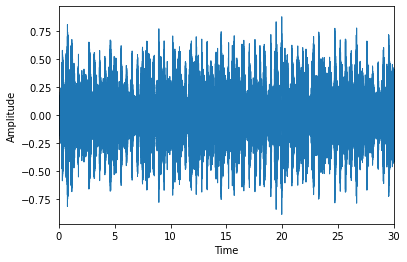

In [7]:
librosa.display.waveplot(signal, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

# FFT to Spectrum

In [8]:
fft = np.fft.fft(signal)
magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))

In [9]:
left_frequency = frequency[:len(frequency)//2]
left_magnitude = magnitude[:len(magnitude)//2]

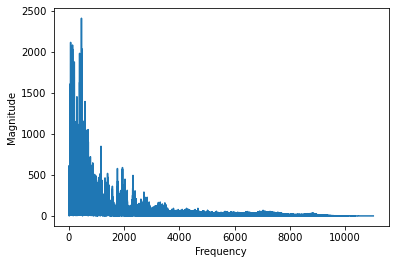

In [10]:
plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

# STFT to Spectrogram

In [11]:
# window we are considering when we are performing single fft
n_fft = 2048
# how much the window slides
hop_length = 512

In [12]:
stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)
spectogram = np.abs(stft)
log_spectogram = librosa.amplitude_to_db(spectogram)

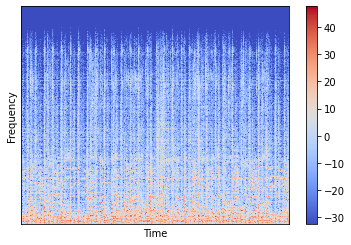

In [13]:
librosa.display.specshow(log_spectogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

# MFCC

In [14]:
MFFC = librosa.feature.mfcc(signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

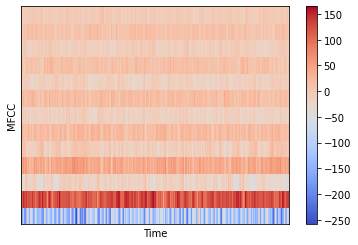

In [15]:
librosa.display.specshow(MFFC, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

# Dataset Preprocessing

In [16]:
import os
import math
import json

In [17]:
# the data.json is too large to have in one file on github, so we need to create the file ourselves
!ls data_json_split
!rm -f data.json
!cat data_json_split/data* >> data.json

data00
data01
data02
data03
data04
data05
data06
data07
data08


rm: cannot remove 'data.json': No such file or directory


In [18]:
DATASET_PATH = "datasets/genres"
JSON_PATH = "data.json"

SAMPLE_RATE = 22050
DURATION = 30 # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

In [19]:
def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    '''
    dataset_path -> path to dataset (hardcoded above)
    n_mfcc -> number of coeff to extract
    n_ftt -> interval we consider when doing fft
    hop_length -> sliding window for fft
    num_segments -> num of seg we divide sample tracks into
    '''
    # mfcc is training input
    # labels are outputs
    data = {
        "mapping": [], # classicals, blues, etc
        "mfcc": [],
        "labels": [] # 0, 1, etc
    }
    
    samples_per_seg = SAMPLES_PER_TRACK // num_segments    
    num_mfcc_vectors_per_seg = math.ceil(samples_per_seg / hop_length)
    
    # loop through all genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        # dirpath is path to folder we are in
        # dirname are the names of the subfolders in dirpath
        # filenames are the names of the files in dirpath
        
        # make sure we are not at root level
        if dirpath is not dataset_path:
            # save the genre name
            dirpath_components = dirpath.split('/') # genre/classical => ['genre', 'classical']
            data["mapping"].append(dirpath_components[-1])
            
            # process files for specific genre
            for f in filenames:
                file_path = os.path.join(dirpath, f)
                # load audio
                signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                
                # process segments and get mfcc
                for s in range(0, num_segments):
                    start_sample = samples_per_seg * s
                    finish_sample = start_sample + samples_per_seg
                    
                    mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample],
                                               sr=sr,
                                               n_fft=n_fft,
                                               n_mfcc=n_mfcc,
                                               hop_length=hop_length)
                    
                    mfcc = mfcc.T
                    # store mfcc for seg if expected length matches
                    if len(mfcc) == num_mfcc_vectors_per_seg:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [20]:
if not os.path.isfile(JSON_PATH):
    save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

# Load Data

In [21]:
def load_data(dataset_path):
    with open(dataset_path, "r") as fp:
        data = json.load(fp)
        
    # convert list to numpy
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])
    return inputs, targets

In [22]:
X, y = load_data(JSON_PATH)

In [23]:
X.shape

(29991, 44, 13)

# Split Data

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
def prepare_datasets(test_size, validation_size):
    # create our train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    # create train/validation split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)
    
    # CNN expects 4d
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    
    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [26]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(test_size=0.25, validation_size=0.2)

In [27]:
X_train.shape

(17994, 44, 13, 1)

# Create Model

In [28]:
import tensorflow as tf

In [29]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((3,3), strides=(2,2), padding='same'),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((3,3), strides=(2,2), padding='same'),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(32, (2,2), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2), strides=(2,2), padding='same'),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),


    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(10, activation='softmax')
])

In [30]:
optimizer = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 42, 11, 128)       1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 9, 128)        147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 5, 128)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 5, 128)        512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 3, 64)         73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 2, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 2, 64)          2

In [32]:
history = None
weights_path = "weights_final.h5"

if not os.path.isfile(weights_path):
    history = model.fit(X_train, y_train,
        validation_data=(X_validation, y_validation),
        epochs=50,
        batch_size=32
    )
else:
    print("Weights exist")
    model.load_weights(weights_path)
    print("Loaded weights")

Weights exist
Loaded weights


In [33]:
test_error, test_accuracy = model.evaluate(X_test, y_test)
print(test_accuracy)

235/235 [==============================] - 15s 62ms/step - loss: 0.4126 - accuracy: 0.8981
0.8981061577796936


# Plot Graphs

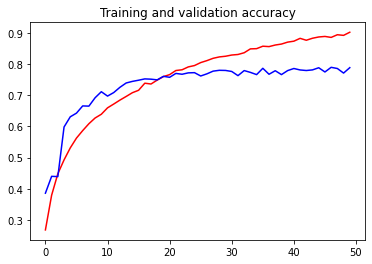

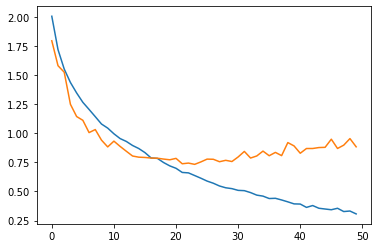

In [34]:
import pickle

history_file = "history_dict"
if os.path.isfile(history_file):
    history = pickle.load(open(history_file, "rb"))
    
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)

    plt.show()
else:
    print("No history file, so cannot show graphs")

# Prediction with YouTube Video

In [35]:
def predict(X, y, should_print=False):
    X = X[np.newaxis, ...]
    prediction = model.predict(X)
    if should_print:
        print('Expected: {}, Predicted: {}'.format(y, np.argmax(prediction, axis=1)))
    return prediction[0]

In [43]:
!pip install youtube_dl

In [36]:
def find_duration(filename):
    duration = int(librosa.get_duration(filename=filename))
    duration = 30 * (duration // 30)
    return duration

In [42]:
def split_song_intervals(duration, filename):
    !rm test_audio_*
    
    prev = 0    
    while prev != duration:
        fn = 'test_audio_out' + str(prev) + '.wav'
        !ffmpeg -hide_banner -loglevel warning -i $filename -ss $prev -t 30 $fn
        prev += 30

In [38]:
def find_signal_and_sample():
    signal_list = []
    sample_rate_list = []

    for filename in os.listdir('.'):
        if filename.startswith('test_audio_out') \
            and filename.endswith('.wav'):
            (signal, sample_rate) = librosa.load(os.path.join('.',
                    filename), sr=SAMPLE_RATE)
            signal_list.append(signal)
            sample_rate_list.append(sample_rate)

    return (signal_list, sample_rate_list)

In [41]:
def find_predictions(signal_list, sample_rate_list):
    f = np.array(range(10), dtype='float64')
    t = []

    num_mfcc = 13
    n_fft = 2048
    hop_length = 512
    num_segments = 30  # changed from 10
    samples_per_seg = SAMPLES_PER_TRACK // num_segments
    num_mfcc_vectors_per_seg = math.ceil(samples_per_seg / hop_length)

    for i in range(0, len(signal_list)):
        signal = signal_list[i]
        sample_rate = sample_rate_list[i]

        for d in range(num_segments):
            start = samples_per_seg * d
            finish = start + samples_per_seg
            mfcc = librosa.feature.mfcc(signal[start:finish],
                    sample_rate, n_mfcc=num_mfcc, n_fft=n_fft,
                    hop_length=hop_length)
            mfcc = mfcc.T
            if len(mfcc) == num_mfcc_vectors_per_seg:
                t.append(mfcc.tolist())

        t = np.array(t)
        
        # weird bug, fails when its num_segments but works on colab
        for d in range(num_segments - 1):
            p = predict(t[d].reshape(-1, 13, 1), 2)
            f += p / np.linalg.norm(p)
        t = []
    return f

In [54]:
def plot_predictions(f, title):
    plt.bar(range(0, 10), f)
    plt.ylabel('% Chance')
    plt.xlabel('Genre')
    plt.xticks(np.arange(10), [
        'rock', 
        'country',
        'pop',
        'metal',
        'reggae',
        'blues',
        'classical',
        'jazz',
        'hiphop',
        'disco',
        ], rotation=90)
    if title:
        plt.title(title)
    plt.show()

In [45]:
def predict_song_genre(youtube_url, title=None):
    filename = 'in.wav'

    !rm -f $filename
    !youtube-dl -q --extract-audio --audio-format wav --output $filename $youtube_url
    
    print("Downloaded Youtube wav")

    duration = find_duration(filename)
    
    print('Found duration: {} seconds'.format(duration))

    split_song_intervals(duration, filename)
    
    print("Split song into intervals")

    (signal_list, sample_rate_list) = find_signal_and_sample()
    
    print("Found signal and sample for each interval")

    f = find_predictions(signal_list, sample_rate_list)
    
    print("Found predictions")
    
    return f, title

In [46]:
f1, t1 = predict_song_genre("https://www.youtube.com/watch?v=lDK9QqIzhwk",
                   title="Bon Jovi - Livin' on a Prayer")

Downloaded Youtube wav
Found duration: 240 seconds
Split song into intervals
Found signal and sample for each interval
Found predictions


In [47]:
f2, t2 = predict_song_genre("https://www.youtube.com/watch?v=1vrEljMfXYo",
                   title="John Denver - Country Roads")

Downloaded Youtube wav
Found duration: 180 seconds
Split song into intervals
Found signal and sample for each interval
Found predictions


In [48]:
f3, t3 = predict_song_genre("https://www.youtube.com/watch?v=aJOTlE1K90k",
               title="Maroon 5 - Girls like You")

Downloaded Youtube wav
Found duration: 270 seconds
Split song into intervals
Found signal and sample for each interval
Found predictions


In [49]:
f4, t4 = predict_song_genre("https://www.youtube.com/watch?v=BN0d9je-DHQ",
               title="Beethoven - Symphony No. 5 [Short]")

Downloaded Youtube wav
Found duration: 150 seconds
Split song into intervals
Found signal and sample for each interval
Found predictions


In [50]:
f5, t5 = predict_song_genre("https://www.youtube.com/watch?v=fNFzfwLM72c",
               title="Bee Gees - Stayin' Alive")

Downloaded Youtube wav
Found duration: 240 seconds
Split song into intervals
Found signal and sample for each interval
Found predictions


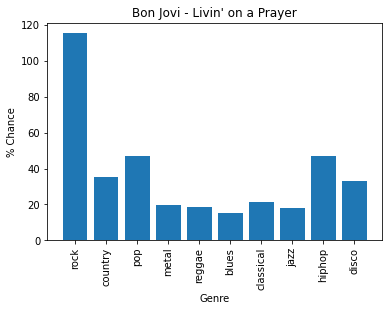

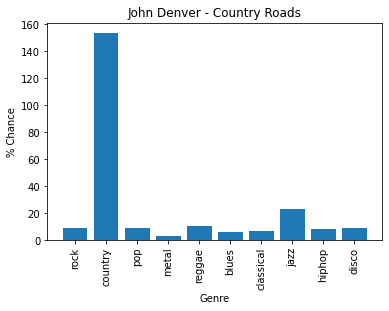

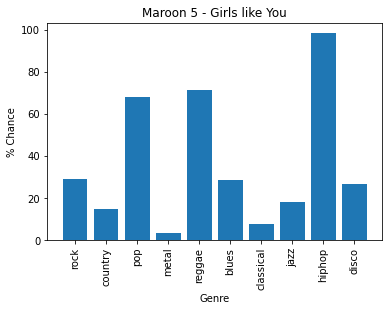

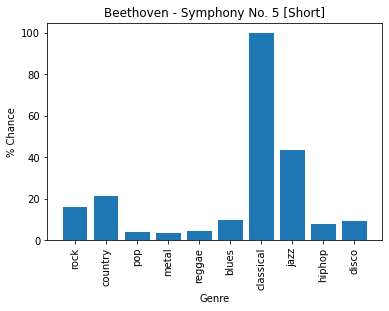

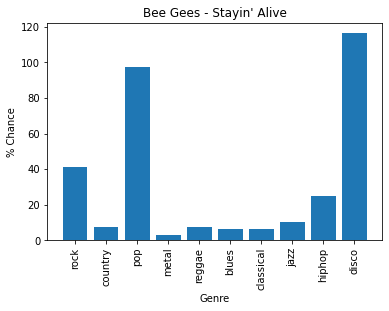

In [56]:
f_list = [f1, f2, f3, f4, f5]
t_list = [t1, t2, t3, t4, t5]

for i in range(0, len(f_list)):
    plot_predictions(f_list[i], t_list[i])